## Finding Donors for *Charity*

## Getting Started

In this project several supervised learning algorithms were employed to accurately model individuals' income using data collected from the 1994 U.S. Census. The best candidate algorithm from preliminary results were chosen and further optimized to best model the data. The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000.

----
## Exploring the Data
The last column from this dataset, `'income'`, will be the target label (whether an individual makes more than, or at most, $50,000 annually).

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset to determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. 

In [2]:
# Total number of records
n_records = len(data.index)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income'].str.contains('>50K')])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'].str.contains('<=50K')])

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = 100*(float(n_greater_50k) / float(n_records))

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data

### Transforming Skewed Continuous Features

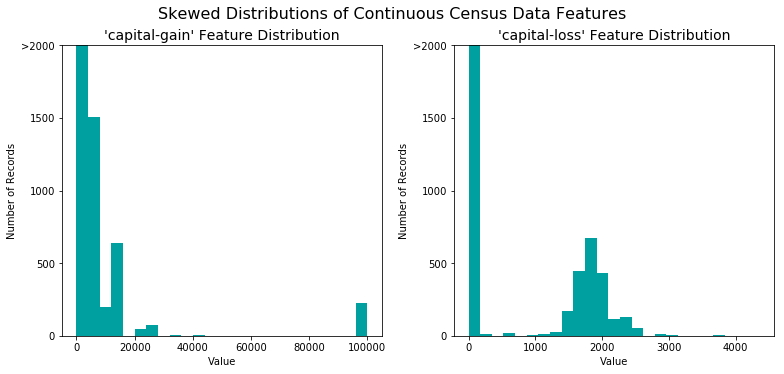

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

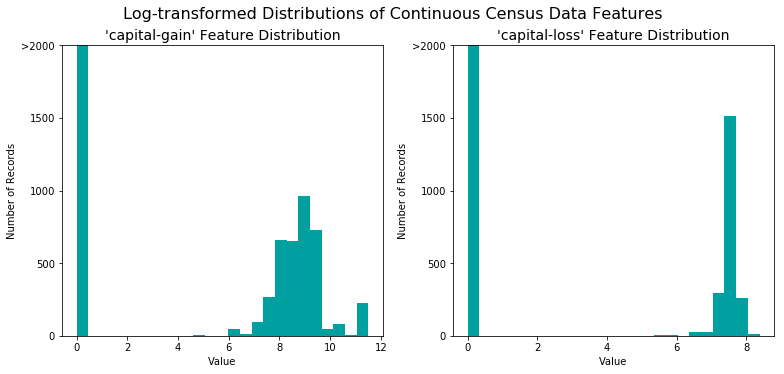

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Normalization ensures that each feature is treated equally when applying supervised learners.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


In [6]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K': 0, '>50K': 1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 1)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data.

### Naive Predictor Performace

In [8]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
                    # encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = float(TP + TN)/(TP + TN + FP + FN)
recall = float(TP)/(TP + FN)
precision = float(TP)/(TP + FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
# HINT: The formula above can be written as (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
beta = 0.5
fscore = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Model Application

What's known about the data

    45222 dataset
    sparse data after performing one hot encoding
    predictions are binary classifications
    data has 8 categorical and 5 continuous features
    target variable is not evenly distributed, lower income earners outnumber high income earners approx 3 to 1
    


Supervised learning algorithms and an example application

logistic regression

-Used for predicting mortality in injured patients
https://en.wikipedia.org/wiki/Logistic_regression#Fields_and_example_applications

-Strengths are quick to train resistant to overfitting
http://courses.washington.edu/css490/2012.Winter/lecture_slides/05b_logistic_regression.pdf

-Weaknesses are limited to linear decision boundaries
http://courses.washington.edu/css490/2012.Winter/lecture_slides/05b_logistic_regression.pdf



-Expect the data features have a simple relationship to making predictions. One that can be modeled by a linear separator. Expect that the high earners group would most likely have continuous feature values above a certain value. While those making less would more likely have continuous values below this determined value. For categorical data this would again be determined similarly. A suitable linear separator could easily be determined with a logistic regression.




SVM classifier

-Used for computer aided detection in cancer cases
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3372692/
from section 2.3 "Typical applications of kernel-based learning methods in radiology are in CAD. SVMs perform well in detection of microcalcifications on mammography CAD"

-The model performs well for varied cases due to a multitude of possible kernels available
http://scikit-learn.org/stable/modules/svm.html

-Does not readily predict probabilities, probabilities requires five fold cross validation
http://scikit-learn.org/stable/modules/svm.html
-Only makes a linear decision boundary




-Similar to the logistic regression classifier in that it only creates linear decision boundary. So would expect to only slightly vary for overall suitability from the logistic regression in how it handles the procedure.





gaussian naive bayes

-Used in classifying text into categories
http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes

-A simple method that is faster than more complicated methods
http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes

-Not a great estimator of probabilities
http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes




-works best on predicting the likely class based on those features which are most probable to that class. Would think that high income earners share features that are found at higher probabilities with other high income earners. If a certain entry has data for a feature that is often seen in entries of high income earners, then this entry is most likely an example of a high income earner.

### Create a Training and Predicting Pipeline


 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test[:])
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Initial Model Evaluation

LogisticRegression trained on 362 samples.
LogisticRegression trained on 3618 samples.
LogisticRegression trained on 36177 samples.
LinearSVC trained on 362 samples.
LinearSVC trained on 3618 samples.
LinearSVC trained on 36177 samples.
GaussianNB trained on 362 samples.
GaussianNB trained on 3618 samples.
GaussianNB trained on 36177 samples.


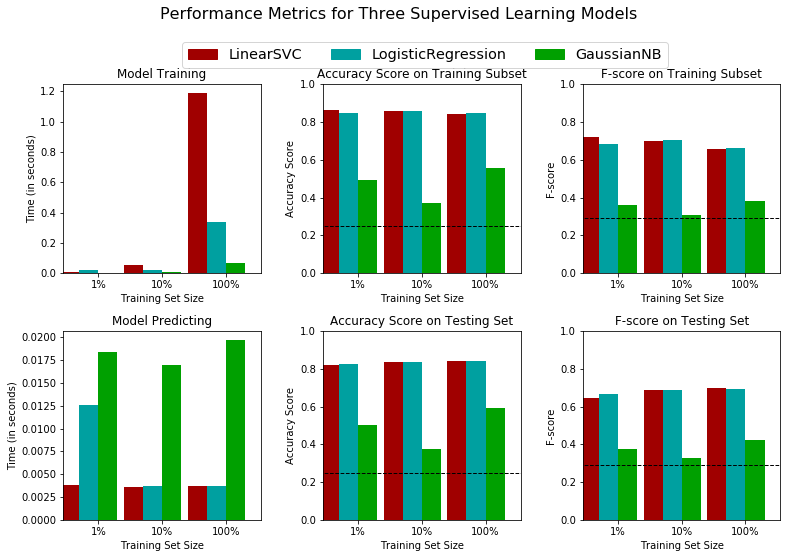

In [10]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

# Initialize the three models
clf_A = LogisticRegression(random_state=1)
clf_B = LinearSVC(C=1.0, random_state=1)
clf_C = GaussianNB()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100
# HINT: samples_1 is 1% of samples_100
samples_100 = len(y_train)
samples_10 = int(round(.1 * samples_100))
samples_1 = int(round(.01 * samples_100))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results With grid Search

After creating three different models with varying algorithms, selecting algorithms based on the requirement to determine if a person does or does not earn 50k a annually. This is a problem where there is only two different possible answers. Selected for this problem for intial testing were the algorithms, linear svc, logistic regression, and gaussian naive bayes. After testing the model most suitable for this application is the logistic regression model. Out of the the models selected for testing on the dataset, the logistic regression displays the best accuracy in determining who makes over 50k annually as shown in the fscore accuracy. The f-score for the logistic regression model is approx .68 when tested on %100 data trained model. The fully naive model which always assumes people make more than 50k has a rating of .2917 for an f score.

The logistic regression also has the benefit of supporting online learning, so it can be kept up to date and more accurate. The model itself is also simple enough to understand. Being a line the constraints are interpretable.

Other models come close in accuracy as well. A linear svc was also determined to be suitable and was tested. Accuracy of the linear svc was comparable to the logistic regression. Though training time was clearly a differentiator between the two models. The logistic regression is far more efficient in creating as accurate a model. The training time for a linear svc model was found to require 1.4 seconds to train on the full training set. The logistic regression required only just greater than .4 sec on the same hardware. A difference of more than %350 in required time. In testing time the linear svc and logistic regression for the 100% dataset were comparable at between .004 s and .005 s.

The gaussian NB model was clearly lacking in f-score and accuracy when compared to the other models. This is likely due to NB models suffering from high bias due to being such a simple model, unable to model intricacies of the data.



The model works by finding a line where on one side the data most likely belongs to examples of one category, and on the other side the data is most likely of another category. In this example a data point on one side of the line was determined to be for people making under 50k a year. For this data the model returns a 0. On the other side of the line people more likely make over 50k a year. For this data the model returns a 1. The model doesn't return a number for how confident it is about the decision. It only returns whether or not a data entry, in this case a person. For simple problems where possibilities of what category some data entry belongs to is limited, logistic regressions are one of the most used methods. They return only what is needed for making decisions and require less computing than other comparable methods.

The way the model is trained is by feeding in data entries with their corresponding categories known. The model is then created by determining where a line is most accurate in dividing the data into belonging to different categories.

In [12]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = LogisticRegression(random_state=1)

# Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'C': [.01, .1, 1, 10, 100],
              'penalty': ['l2', 'l1']}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8407
F-score on testing data: 0.6909

Optimized Model
------
Final accuracy score on the testing data: 0.8405
Final F-score on the testing data: 0.6913


### Final Model Evaluation

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |   0.2478            |   0.8407          |   0.8405        |
| F-score        |   0.2917            |   0.6909          |   0.6913        |


**Answer: **

The optimized model has a slightly increased f-score of .6913 over the unoptimized model's .6909. 
Both have accuracy scores and f scores markedly above the naive predictor.

----
## Feature Importance

1. hours per week: When someone works 40 hours a week this is likely considered a full time job, likely a salaried job. Full time jobs usually pay more than part time work. Hours per week can also show commitment to work and higher commitment generally means higher compensation.

2. occupation: For most people their income is almost entirely dependent on their job. Income may largely be determined by type of employment.

3. age: Some occupations require gradual building of experience and business connections. This would be seen in age.

4. education level: Possibly closely tied to occupation is education level. Competitive jobs which pay well require skills. Education and experience are how skills are obtained.

5. sex: It is well known that generally in the US there is a wage gap between men and women. Also men have traditionally been seen as having the roll of supporting a household financially and may seek this roll.

### Extracting Feature Importance

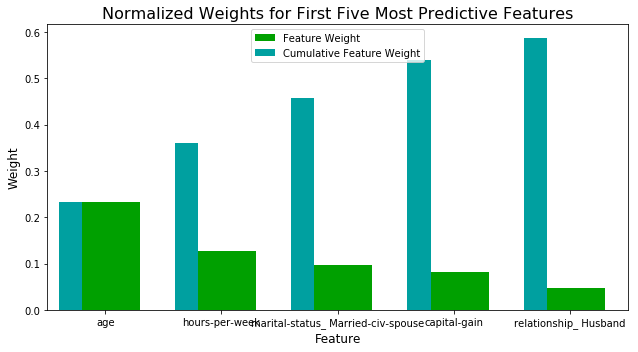

In [13]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import ExtraTreesClassifier

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
clf = ExtraTreesClassifier()
model = clf.fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

Of the top 5 most significant factors in determining a persons income, whether above of below $50000 annually, the answers given in question 6 and the results returned by the algorithm have 2 features in common. The features age and hours worked per week are the top one and two spots respectively returned by the algorithm. It could also be noted that the fifth most significant feature returned by the algorithm is relationship-husband. This intrinsically takes into account sex. Sex was the fifth most significant factor in determining income given in question 6.

This visualization confirms on the common features that age and hours per week are the most significant features. Age likely a proxy for experience, skill, and connections. The importance of hours-per-week for how currently involved a person is to their work. The more involved someone is, the more compensation they are likely to receive.

The features capital-gain, returned as the fourth most significant feature, is likely significant in how direct it is in relation to income. If someone has the resources to have large amounts of funds tied up in investing to get more significant returns. Then they likely have work that affords for them to put larger funds into investments. Marital-status_Married-civ-spouse as the third most significant feature as returned by the algorithm shows that having a stable living environment is tied to having higher income.

### Feature Selection

Using fewer features at the benefit of data gathering and computation

In [14]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8405
F-score on testing data: 0.6913

Final Model trained on reduced data
------
Accuracy on testing data: 0.7782
F-score on testing data: 0.4973


### Effects of Feature Selection

There was a drop of .194 of the f-score in using the reduced features set.

With training time being an issue, the logistic regression is already a quick model. If training is still an issue in this particular case I would first consider reducing the training set size. The 10% training set size trained in a small fraction of the time and had little to no drop in f-score.

When comparing equal training set sizes and resources are still a factor then balancing the number of features considered may be worth balancing against other costs, such as costs of engaging with a lower f-score result and the resulting fewer responses from the target people.